# Capstone Project: Battle of Neighborhoods

Created with IBM Watson Studio by Tom Nel

# Suitable locations for a techno club in Brussels

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

Although the techno scene in Brussels is not on the same level as Berlin's, the Belgian capital has an exciting nightlife and many techno clubs offer a great night out till early morning. There is reason enough to believe however that another techno temple could add to the various options Brussels' night owls already have: many artists in the techno scene reside in Brussels and sometimes it is difficult for them to show off their talent as the established techno clubs already have limited available slots to perform. Moreover, a frustrating aspect of the clubs are the waiting lines, which indicates that there are many enthusiasts of techno, though mostly only a limited amount of people are allowed inside at the same time. That's why I've decided to use location data and other considerations to offer the best feasible location in Brussels if a new techno club were to be built.


#### Approach and Criteria

_1st Analysis_

In Berlin, most of the techno clubs are located in the district "Friedrichshain". In general, there is a thriving nightlife scene and therefore we will set this neighborhood against all municipalities in Brussels and analyze which municipality resembles this Berlin neighborhood the most. 

_2nd Analysis_

If multiple municipalities are similar to Friedrichshain after performing a general comparison, a deeper analysis will be made to further distinct the most favorable neighborhood in Brussels. 
When searching the perfect location for a new techno club, many other aspects could be considered such as safety, accessibility, type of neighborhood, etc. In my project I've decided to further distinguish a favorable location based on following criteria.

First of all, a lot of nightclubs are coping with noise disturbance and this is something that can be reduced but not dissappear. As such, a distinction will be made between neighborhoods and residential areas will be left out of the options. The new location should be in a neighborhood where already __a lot of bars are present__, as many people tend to roll over from bars to nightclubs once they have a few beers in. Finally, we will compare __the amount of nightclubs already present__ in the neighborhoods and make appropriate recommendations based on the findings. 



#### Outcomes

After these two analyses, we should be able to narrow it down to one single most favorable neighborhood. It has to be emphasized that this is merely a hypothetical question as the data foursquare provides us gives recommended venues, not all the venues in a neighborhood and as such is not complete, which might skew a neighborhood's properties.

To summarize, the goal is to identify the best districts in Brussels to open a new techno club. A district which is similar to Friedrichshain *and* meets the most of the criteria laid out in the above section. The results will be translated in a simple form that will convey the data-driven analysis for the best locations.

#### Target Audience

This analysis could be helpful for future business owners in the nightlife industry or hospitality in general, to identify criteria that are important to consider when opening a new venue.

## 2. Data description and approach <a name="data"></a>

For the project objectives to be achieved, python geolocation libraries will used, along with the Foursquare API. Also, in order to create clusters of similar candidate locations, the K- Means machine learning clustering algorithm will be used.



#### The following data will be needed to make several analyses:

* Data information on the specific Berlin "Friedrichshain" district
* List of the different municipalities in Brussels (<https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region>)
* Foursquare venue data for the respective municipalities
* Foursquare venue data for the Berlin district


Using geolocation libraries, we will add the lattitude and longitude values of the respective districts to allow comparison using foursquare location data. This data will be used to explore the Brussels' neighborhoods on the above criteria and to compare the districts with Friedrichshain to find similar neighborhoods in Brussels. 


#### How the data will be used to solve the problem


The data will be used as follows:

_Analysis 1_ 

I will make a comparison based on the type of venues that are most common in the Friedrichshain district and municipalities of Brussels. I will then perform a clustering algorithm using K-means to determine which of the municipalities are most similar to the Friedrichshain district. 

The goal of K-means clustering is to find groups in the data. K stands for the number of groups. Data points are clustered based on the similarity of the features. So the more similar the data features, the more likely they will be grouped. The municipalities that we ultimately look for are the ones in the same cluster with Friedrichshain. 

_Analysis 2_

Once we have the similar neighborhoods in Brussels, the foursquare and geopy data will be used to find the best one out of those neighborhoods. The amount of nightclubs and amount of bars present and whether the neigbhorhood is residential or not will be used to differentiate the best neighborhood from the good ones. 
 


The procesing of this data will allow to answer the key question:

*Which neighborhood in Brussels, similar to Friedrichshain, has the best properties to open a new techno club, given our limited data availability and assumptions?*

### Data wrangling

First let's retrieve the data of the municipalities in Brussels from the Wikipedia source with BeautifulSoup. The necessary libraries are also imported. 

In [2]:
!pip install folium
import folium
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

%matplotlib inline

website_url = requests.get('https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region').text

soup = BeautifulSoup(website_url,'html.parser')

# Extract the relevant table
table = soup.find('table',{'class':'wikitable sortable'})

     |████████████████████████████████| 92kB 17.8MB/s eta 0:00:01


Now let's extract the municipalities and manually add Friedrichshain. We should become a list with all the municipalities of Brussels and the Friedrichshain district. 

In [3]:
td1 = table.find_all('td',{'style':"text-align:left"})

str_td1 = (str(td1))
str_td1 = str_td1.replace("[", '').replace("]", '').replace(",", '').replace("*", '')  # Clean up the string

td2 = BeautifulSoup(str_td1,'html.parser').getText(' ') # Get the text without html code

# Clean up the cells
municipalities = td2.replace( "*","")
municipalities = td2.split(" \n   ")
municipalities = municipalities[::2] # Only take the French versions of the names
municipalities.append("Friedrichshain") # Add Friedrichshain
municipalities[6] = 'Vorst' # Forest returns wrong coordinates in the geocoder
municipalities

['Anderlecht',
 'Auderghem',
 'Berchem-Sainte-Agathe',
 'Bruxelles-Ville',
 'Etterbeek',
 'Evere',
 'Vorst',
 'Ganshoren',
 'Ixelles',
 'Jette',
 'Koekelberg',
 'Molenbeek-Saint-Jean',
 'Saint-Gilles',
 'Saint-Josse-ten-Noode',
 'Schaerbeek',
 'Uccle',
 'Watermael-Boitsfort',
 'Woluwe-Saint-Lambert',
 'Woluwe-Saint-Pierre',
 'Friedrichshain']

This looks good. Let's also extract the population data for each of the municipalities and Friedrichshain.

In [4]:
td_pop = table.find_all('td',{'style':"text-align:right;"})

str_td_pop = (str(td_pop))
str_td_pop = str_td_pop.replace("[", '').replace("]", '').replace(",", '').replace("*", '')  # Clean up the string

td_pop_bs = BeautifulSoup(str_td_pop,'html.parser').getText(' ') # Get the text without html code

population = td_pop_bs.replace( "*","")
population = td_pop_bs.split("\n   ")
population = population[::2] # Only take the population data and skip population density data
population.append("133754") # Add population of Friedrichshain
population

['118241',
 '33313',
 '24701',
 '176545',
 '47414',
 '40394',
 '55746',
 '24596',
 '86244',
 '51933',
 '21609',
 '96629',
 '50471',
 '27115',
 '133042',
 '82307',
 '24871',
 '55216',
 '41217',
 '133754']

Time to put this data into a dataframe, which we will call df. 

In [5]:
df = pd.DataFrame(
    {'Neighborhood': municipalities,
     'Population': population
    })

df

,Neighborhood,Population
0,Anderlecht,118241
1,Auderghem,33313
2,Berchem-Sainte-Agathe,24701
3,Bruxelles-Ville,176545
4,Etterbeek,47414
5,Evere,40394
6,Vorst,55746
7,Ganshoren,24596
8,Ixelles,86244
9,Jette,51933


A first look at the numbers tells us that Friedrichshain has a comparable population. Lets put it into a graph and see the different population numbers for each neighborhood.

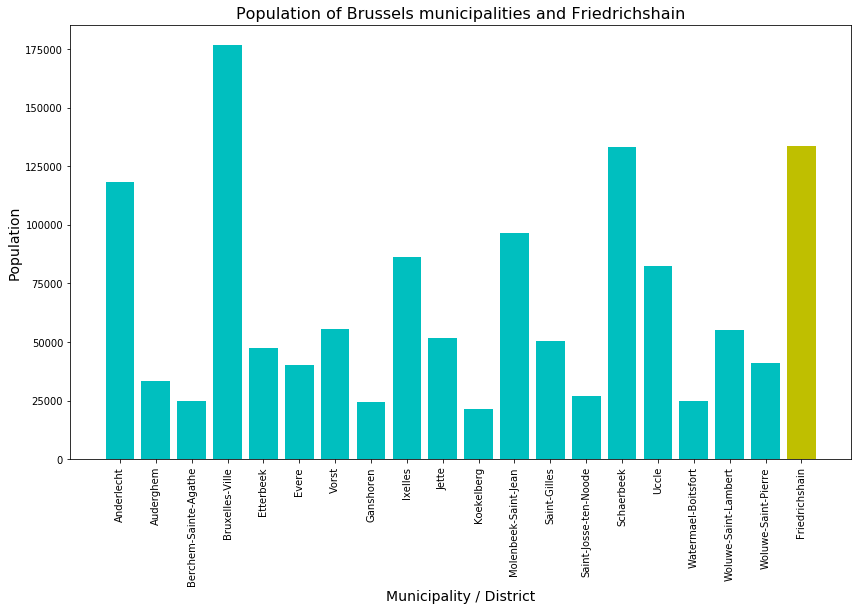

In [6]:
fig = mpl.pyplot.gcf()
fig.set_size_inches(14, 8, forward=True)

df[['Population']] = df[['Population']].apply(pd.to_numeric)

plt.bar(df.index, df['Population'], color=['c', 'c', 'c', 'c', 'c','c', 'c', 'c', 'c', 'c','c', 'c', 'c', 'c', 'c','c', 'c', 'c', 'c', 'y'])
plt.xticks(df.index, df['Neighborhood'], rotation=90)
plt.xlabel('Municipality / District', size=14) # add to x-label to the plot
plt.ylabel('Population', size=14) # add y-label to the plot
plt.title('Population of Brussels municipalities and Friedrichshain', size=16) # add title to the plot
plt.show()

Lets add geolocation data/coordinates to our existing dataframe. To do this, a geocoder called Nominatim is installed. This geocoder extracts the exact coordinates for each district based on their address. 

In [8]:
!conda install -c conda-forge geopy --yes

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [7]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.point import *

In [8]:
#Add the city names to make the locations unique (Ex. Reims has also a district named Saint-Gilles)

latitude=[]
longitude=[]
district_and_city = [mun + ", Bruxelles" for mun in municipalities[:19]] 
district_and_city.append(municipalities[19] + ", Berlin")
print(district_and_city)

['Anderlecht, Bruxelles', 'Auderghem, Bruxelles', 'Berchem-Sainte-Agathe, Bruxelles', 'Bruxelles-Ville, Bruxelles', 'Etterbeek, Bruxelles', 'Evere, Bruxelles', 'Vorst, Bruxelles', 'Ganshoren, Bruxelles', 'Ixelles, Bruxelles', 'Jette, Bruxelles', 'Koekelberg, Bruxelles', 'Molenbeek-Saint-Jean, Bruxelles', 'Saint-Gilles, Bruxelles', 'Saint-Josse-ten-Noode, Bruxelles', 'Schaerbeek, Bruxelles', 'Uccle, Bruxelles', 'Watermael-Boitsfort, Bruxelles', 'Woluwe-Saint-Lambert, Bruxelles', 'Woluwe-Saint-Pierre, Bruxelles', 'Friedrichshain, Berlin']


In [9]:
for dac in district_and_city:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(dac)
    lat = location.latitude
    long = location.longitude
    latitude.append(lat)
    longitude.append(long)
print(latitude, longitude)

[50.8390983, 50.8172355, 50.8649231, 50.8465573, 50.8361447, 50.8720096, 50.811795, 50.8703273, 50.8331141, 50.8759585, 50.8606042, 50.8545959, 50.8267409, 50.8508197, 50.8676041, 50.8035441, 50.7981063, 50.8430448, 50.8370253, 52.5122154] [4.3296526, 4.4268982, 4.2946734, 4.351697, 4.3861737, 4.4034182, 4.3181187, 4.307798, 4.3668279, 4.3245702, 4.3315503, 4.338636, 4.345668, 4.3691634, 4.3737121, 4.3338445, 4.4176441, 4.4256732, 4.4274636, 13.4502904]


Adding the new coordinates to our existing dataframe with the municipalities gives us a more complete dataframe with the relevant information. 

In [10]:
lat_ser = pd.Series(latitude)
lon_ser = pd.Series(longitude)

df['Latitude'] = lat_ser.values
df['Longitude'] = lon_ser.values

df.head(20)

,Neighborhood,Population,Latitude,Longitude
0,Anderlecht,118241,50.839098,4.329653
1,Auderghem,33313,50.817236,4.426898
2,Berchem-Sainte-Agathe,24701,50.864923,4.294673
3,Bruxelles-Ville,176545,50.846557,4.351697
4,Etterbeek,47414,50.836145,4.386174
5,Evere,40394,50.872010,4.403418
6,Vorst,55746,50.811795,4.318119
7,Ganshoren,24596,50.870327,4.307798
8,Ixelles,86244,50.833114,4.366828
9,Jette,51933,50.875959,4.324570


Lets create a map using folium to have a look at the different municipalities in Brussels

In [11]:
# create map using latitude and longitude values
latitude_bru = 50.802398
longitude_bru = 4.340670

map_brussels = folium.Map(location=[latitude_bru, longitude_bru], zoom_start=10)

# add markers to map
for lat, lng, municipalities in zip(latitude, longitude, municipalities):
    label = '{}'.format(municipalities)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_brussels)  
    
map_brussels

## 3. Methodology <a name="methodology"></a>

The goal is to identify the best district in Brussels to open a new techno club. A district which is similar to Friedrichshain and meets the criteria laid out in the data section. 

Now that we have the districts and their respective coordinates in a dataframe, we will continue as follows: 

- Foursquare location data extraction for each district: getting a list of nearby venues in each district (non-exhaustive!) with general explore function
- One-hot encoding to make the data ready for a K-means clustering algorithm
- K-means clustering algorithm
- Cluster Analysis

Once we have the different clusters, a further analysis will be made for the cluster with Friedrichshain in it. A new foursquare query with the explore function, but this time the extracted venues are  restricted to the "Nightlife" category. A specific category ID will be used in the explore function.

- Get nearby venues with explore function restricted to "Nightlife" venues only
- Get top 10 nightlife venues for each neighborhood in the cluster with feasible neighborhoods
- Visualize the different neighborhoods set out against amount of bars and amount of nightclubs
- Draw conclusions

## 4. Analysis <a name="analysis"></a>

### 4.1. Foursquare location data extraction

Now that we have our relevant locations with coordinates, lets make use of the foursquare location data to analyse and compare the districts.

In [32]:
#Foursquare credentials
CLIENT_ID = 'KFTEPII41FOAMNLIN0ZPH3SR5PPDUIIB5RQYEQXMSZSH2B0D' # your Foursquare ID
CLIENT_SECRET = 'LCGOCL0UQUTECYRVULD05US0KWUHA0TGDPERWEPB4M5WWDQ0' # your Foursquare Secret
VERSION = '20200417'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KFTEPII41FOAMNLIN0ZPH3SR5PPDUIIB5RQYEQXMSZSH2B0D
CLIENT_SECRET:LCGOCL0UQUTECYRVULD05US0KWUHA0TGDPERWEPB4M5WWDQ0


In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Assumption: radius = 1km to avoid cross-overs

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT,
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
mun_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                
                                  )

Anderlecht
Auderghem
Berchem-Sainte-Agathe
Bruxelles-Ville
Etterbeek
Evere
Vorst
Ganshoren
Ixelles
Jette
Koekelberg
Molenbeek-Saint-Jean
Saint-Gilles
Saint-Josse-ten-Noode
Schaerbeek
Uccle
Watermael-Boitsfort
Woluwe-Saint-Lambert
Woluwe-Saint-Pierre
Friedrichshain


In [16]:
print(mun_venues.shape)

(1701, 7)


In [34]:
# An exploratory look into the dataframe shows us that not all the nightclubs in the neighborhoods are being incorporated. 
#This is because the foursquare explore function only returns venues they consider to be the most important ones. 
#In our analysis we will restrict this query with the 'nightlife' category id as to obtain more relevant data for our analysis.

clubs = np.array((mun_venues['Venue Category']=='Nightclub'))
clubs = mun_venues[clubs]
clubs

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
665,Ixelles,50.833114,4.366828,Spirito Brussels,50.837315,4.361350,Nightclub
1093,Saint-Gilles,50.826741,4.345668,Fuse,50.835344,4.344928,Nightclub
130,Auderghem,50.817236,4.426898,Le Cactus,50.815776,4.426314,Nightclub
1624,Friedrichshain,52.512215,13.450290,Panorama Bar,52.511151,13.442996,Nightclub
1631,Friedrichshain,52.512215,13.450290,Säule,52.511122,13.442895,Nightclub
1611,Friedrichshain,52.512215,13.450290,Berghain,52.511396,13.443199,Nightclub
1630,Friedrichshain,52.512215,13.450290,Teledisko,52.507504,13.454294,Nightclub


### 4.2. First analysis

In [35]:
# one hot encoding
mun_onehot = pd.get_dummies(mun_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mun_onehot['Neighborhood'] = mun_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mun_onehot.columns[-1]] + list(mun_onehot.columns[:-1])
mun_onehot = mun_onehot[fixed_columns]

mun_onehot.head()


,Neighborhood,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
337,Bruxelles-Ville,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
940,Molenbeek-Saint-Jean,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
957,Molenbeek-Saint-Jean,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1081,Saint-Gilles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
680,Ixelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
mun_onehot = mun_onehot.groupby('Neighborhood').mean().reset_index()
mun_grouped = mun_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in mun_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mun_grouped[mun_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anderlecht----
               venue  freq
0     Sandwich Place  0.10
1              Hotel  0.06
2  French Restaurant  0.05
3        Coffee Shop  0.05
4   Greek Restaurant  0.03


----Auderghem----
                venue  freq
0  Italian Restaurant  0.06
1               Plaza  0.05
2              Bakery  0.05
3          Restaurant  0.03
4                Park  0.03


----Berchem-Sainte-Agathe----
               venue  freq
0        Supermarket  0.06
1  Electronics Store  0.06
2                Bar  0.04
3         Restaurant  0.04
4   Greek Restaurant  0.04


----Bruxelles-Ville----
            venue  freq
0  Chocolate Shop  0.07
1       Bookstore  0.06
2             Bar  0.06
3           Plaza  0.05
4  Clothing Store  0.04


----Etterbeek----
                venue  freq
0  Italian Restaurant  0.10
1            Wine Bar  0.04
2      Sandwich Place  0.04
3              Bakery  0.03
4         Coffee Shop  0.03


----Evere----
         venue  freq
0         Park  0.07
1  Supermarket  0.06


In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mun_grouped['Neighborhood']

for ind in np.arange(mun_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mun_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,Sandwich Place,Hotel,French Restaurant,Coffee Shop,Supermarket,Bar,Greek Restaurant,Indian Restaurant,Italian Restaurant,Food Court
1,Auderghem,Italian Restaurant,Bakery,Plaza,Middle Eastern Restaurant,Fast Food Restaurant,Park,Convenience Store,Pizza Place,Restaurant,French Restaurant
2,Berchem-Sainte-Agathe,Electronics Store,Supermarket,Gym,Greek Restaurant,Restaurant,Bar,Clothing Store,Snack Place,Brasserie,Pharmacy
3,Bruxelles-Ville,Chocolate Shop,Bar,Bookstore,Plaza,Hotel,Coffee Shop,Clothing Store,Seafood Restaurant,Sandwich Place,Italian Restaurant
4,Etterbeek,Italian Restaurant,Wine Bar,Sandwich Place,Hotel,Bakery,Greek Restaurant,History Museum,Vietnamese Restaurant,Coffee Shop,Gym / Fitness Center
5,Evere,Park,Bar,Snack Place,Supermarket,Friterie,Pizza Place,Sandwich Place,Tram Station,Paper / Office Supplies Store,Bakery
6,Friedrichshain,Café,Pizza Place,Coffee Shop,Nightclub,Falafel Restaurant,Pub,Hostel,Middle Eastern Restaurant,Thai Restaurant,Ice Cream Shop
7,Ganshoren,Bar,Plaza,Restaurant,Electronics Store,Pizza Place,Convenience Store,Supermarket,Chinese Restaurant,Italian Restaurant,Pharmacy
8,Ixelles,Italian Restaurant,Hotel,Coffee Shop,Wine Bar,Plaza,Cocktail Bar,Bar,Clothing Store,Tea Room,Boutique
9,Jette,Bar,Plaza,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Park,Supermarket,Convenience Store,Gastropub


#### K-means Analysis

Assumption: 5 clusters give the best results.

In [21]:
kclusters = 5

mun_grouped_clustering = mun_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mun_grouped_clustering)

mun_merged = df.copy()

# add clustering labels
mun_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mun_merged = mun_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mun_merged.head(20) # check the last columns!

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,118241,50.839098,4.329653,1,Sandwich Place,Hotel,French Restaurant,Coffee Shop,Supermarket,Bar,Greek Restaurant,Indian Restaurant,Italian Restaurant,Food Court
1,Auderghem,33313,50.817236,4.426898,3,Italian Restaurant,Bakery,Plaza,Middle Eastern Restaurant,Fast Food Restaurant,Park,Convenience Store,Pizza Place,Restaurant,French Restaurant
2,Berchem-Sainte-Agathe,24701,50.864923,4.294673,0,Electronics Store,Supermarket,Gym,Greek Restaurant,Restaurant,Bar,Clothing Store,Snack Place,Brasserie,Pharmacy
3,Bruxelles-Ville,176545,50.846557,4.351697,2,Chocolate Shop,Bar,Bookstore,Plaza,Hotel,Coffee Shop,Clothing Store,Seafood Restaurant,Sandwich Place,Italian Restaurant
4,Etterbeek,47414,50.836145,4.386174,2,Italian Restaurant,Wine Bar,Sandwich Place,Hotel,Bakery,Greek Restaurant,History Museum,Vietnamese Restaurant,Coffee Shop,Gym / Fitness Center
5,Evere,40394,50.872010,4.403418,4,Park,Bar,Snack Place,Supermarket,Friterie,Pizza Place,Sandwich Place,Tram Station,Paper / Office Supplies Store,Bakery
6,Vorst,55746,50.811795,4.318119,2,Supermarket,Train Station,Park,Bus Stop,Sandwich Place,Pharmacy,Brasserie,Market,Bar,Big Box Store
7,Ganshoren,24596,50.870327,4.307798,0,Bar,Plaza,Restaurant,Electronics Store,Pizza Place,Convenience Store,Supermarket,Chinese Restaurant,Italian Restaurant,Pharmacy
8,Ixelles,86244,50.833114,4.366828,2,Italian Restaurant,Hotel,Coffee Shop,Wine Bar,Plaza,Cocktail Bar,Bar,Clothing Store,Tea Room,Boutique
9,Jette,51933,50.875959,4.324570,2,Bar,Plaza,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Park,Supermarket,Convenience Store,Gastropub


In [22]:
# create map
map_clusters = folium.Map(location=[latitude_bru, longitude_bru], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mun_merged['Latitude'], mun_merged['Longitude'], mun_merged['Neighborhood'], mun_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clusters
Lets have a closer look at each of the clusters

In [25]:
cluster_0 = np.array((mun_merged['Cluster Labels']==0))
cluster_0 = mun_merged[cluster_0]
cluster_0

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Berchem-Sainte-Agathe,24701,50.864923,4.294673,0,Electronics Store,Supermarket,Gym,Greek Restaurant,Restaurant,Bar,Clothing Store,Snack Place,Brasserie,Pharmacy
7,Ganshoren,24596,50.870327,4.307798,0,Bar,Plaza,Restaurant,Electronics Store,Pizza Place,Convenience Store,Supermarket,Chinese Restaurant,Italian Restaurant,Pharmacy
14,Schaerbeek,133042,50.867604,4.373712,0,Snack Place,Supermarket,Bar,Turkish Restaurant,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Doner Restaurant,Park,Music Venue


In [27]:
cluster_1 = np.array((mun_merged['Cluster Labels']==1))
cluster_1 = mun_merged[cluster_1]
cluster_1

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,118241,50.839098,4.329653,1,Sandwich Place,Hotel,French Restaurant,Coffee Shop,Supermarket,Bar,Greek Restaurant,Indian Restaurant,Italian Restaurant,Food Court
10,Koekelberg,21609,50.860604,4.331550,1,Supermarket,Metro Station,Sandwich Place,French Restaurant,Snack Place,Italian Restaurant,Convenience Store,Bar,Gym / Fitness Center,Gym
15,Uccle,82307,50.803544,4.333844,1,Supermarket,French Restaurant,Plaza,Sandwich Place,Bar,Pizza Place,Chinese Restaurant,Park,Italian Restaurant,Cosmetics Shop


In [26]:
cluster_2 = np.array((mun_merged['Cluster Labels']==2))
cluster_2 = mun_merged[cluster_2]
cluster_2

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bruxelles-Ville,176545,50.846557,4.351697,2,Chocolate Shop,Bar,Bookstore,Plaza,Hotel,Coffee Shop,Clothing Store,Seafood Restaurant,Sandwich Place,Italian Restaurant
4,Etterbeek,47414,50.836145,4.386174,2,Italian Restaurant,Wine Bar,Sandwich Place,Hotel,Bakery,Greek Restaurant,History Museum,Vietnamese Restaurant,Coffee Shop,Gym / Fitness Center
6,Vorst,55746,50.811795,4.318119,2,Supermarket,Train Station,Park,Bus Stop,Sandwich Place,Pharmacy,Brasserie,Market,Bar,Big Box Store
8,Ixelles,86244,50.833114,4.366828,2,Italian Restaurant,Hotel,Coffee Shop,Wine Bar,Plaza,Cocktail Bar,Bar,Clothing Store,Tea Room,Boutique
9,Jette,51933,50.875959,4.324570,2,Bar,Plaza,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Park,Supermarket,Convenience Store,Gastropub
11,Molenbeek-Saint-Jean,96629,50.854596,4.338636,2,Bar,Hotel,Theater,Belgian Restaurant,Plaza,Restaurant,Seafood Restaurant,French Restaurant,Italian Restaurant,Art Gallery
12,Saint-Gilles,50471,50.826741,4.345668,2,Italian Restaurant,Bar,Hotel,Brasserie,French Restaurant,Pizza Place,Wine Bar,Beer Bar,Restaurant,Belgian Restaurant
13,Saint-Josse-ten-Noode,27115,50.850820,4.369163,2,Italian Restaurant,Hotel,Concert Hall,Bookstore,Pizza Place,Sandwich Place,Plaza,Snack Place,Gastropub,Park


In [28]:
cluster_3 = np.array((mun_merged['Cluster Labels']==3))
cluster_3 = mun_merged[cluster_3]
cluster_3

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Auderghem,33313,50.817236,4.426898,3,Italian Restaurant,Bakery,Plaza,Middle Eastern Restaurant,Fast Food Restaurant,Park,Convenience Store,Pizza Place,Restaurant,French Restaurant
17,Woluwe-Saint-Lambert,55216,50.843045,4.425673,3,Italian Restaurant,French Restaurant,Sushi Restaurant,Supermarket,Restaurant,Fast Food Restaurant,Park,Clothing Store,Bakery,Asian Restaurant
18,Woluwe-Saint-Pierre,41217,50.837025,4.427464,3,Italian Restaurant,Sandwich Place,Restaurant,Pharmacy,Park,Plaza,French Restaurant,Tram Station,Supermarket,Cocktail Bar
19,Friedrichshain,133754,52.512215,13.450290,3,Café,Pizza Place,Coffee Shop,Nightclub,Falafel Restaurant,Pub,Hostel,Middle Eastern Restaurant,Thai Restaurant,Ice Cream Shop


In [29]:
cluster_4 = np.array((mun_merged['Cluster Labels']==4))
cluster_4 = mun_merged[cluster_4]
cluster_4

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Evere,40394,50.872010,4.403418,4,Park,Bar,Snack Place,Supermarket,Friterie,Pizza Place,Sandwich Place,Tram Station,Paper / Office Supplies Store,Bakery
16,Watermael-Boitsfort,24871,50.798106,4.417644,4,Restaurant,Italian Restaurant,Bus Stop,Park,Ice Cream Shop,Chinese Restaurant,Gastropub,Farmers Market,French Restaurant,Thai Restaurant


As we can see, the k-means cluster analysis puts Friedrichshain in the same cluster with Auderghem, Woluwe-Saint-Lambert and Woluwe-Saint-Pierre. In the next analysis we dig deeper into those 3 neighborhoods and try to find the one that's most similar to Friedrichshain.

### 4.3. Nightlife Analysis

Filtering on 'nightlife' category,  we try to find the best neighborhood out of the 3 that are similar to Friedrichshain (obtained with the k-means analysis).

In [37]:
#categoryID for nightlife venues
nightlifeID = '4d4b7105d754a06376d81259'

As we already made a cluster analysis and only need to investigate the neighborhoods in the cluster with Friedrichshain, we will work with a new dataframe consisting only of those neighborhoods.

In [38]:
neighborhoods = ['Friedrichshain', 'Auderghem', 'Woluwe-Saint-Pierre', 'Woluwe-Saint-Lambert']
df_cluster = df[df['Neighborhood'].isin(neighborhoods)]
df_cluster.head()

,Neighborhood,Population,Latitude,Longitude
1,Auderghem,33313,50.817236,4.426898
17,Woluwe-Saint-Lambert,55216,50.843045,4.425673
18,Woluwe-Saint-Pierre,41217,50.837025,4.427464
19,Friedrichshain,133754,52.512215,13.450290


In [51]:
def getNearbyNightLifeVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            '4d4b7105d754a06376d81259',
            radius,
            LIMIT,
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [56]:
cluster3_venues = getNearbyNightLifeVenues(names=df_cluster['Neighborhood'],
                                   latitudes=df_cluster['Latitude'],
                                   longitudes=df_cluster['Longitude'],
                                
                                  )

Auderghem
Woluwe-Saint-Lambert
Woluwe-Saint-Pierre
Friedrichshain


In [57]:
# one hot encoding
cl3_onehot = pd.get_dummies(cluster3_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cl3_onehot['Neighborhood'] = cluster3_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cl3_onehot.columns[-1]] + list(cl3_onehot.columns[:-1])
cl3_onehot = cl3_onehot[fixed_columns]

cl3_onehot.head()


,Neighborhood,Bar,Beer Bar,Beer Garden,Brewery,Burger Joint,Café,Club House,Cocktail Bar,Convenience Store,...,Karaoke Bar,Liquor Store,Lounge,Music Venue,Nightclub,Pub,Restaurant,Rock Club,Sports Bar,Wine Bar
0,Auderghem,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Auderghem,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Auderghem,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Auderghem,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Auderghem,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
cl3_onehot = cl3_onehot.groupby('Neighborhood').mean().reset_index()
cl3_grouped = cl3_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in cl3_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cl3_grouped[cl3_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auderghem----
                 venue  freq
0                  Bar  0.50
1            Nightclub  0.17
2         Cocktail Bar  0.17
3            Gastropub  0.17
4  Indie Movie Theater  0.00


----Friedrichshain----
          venue  freq
0           Bar  0.29
1     Nightclub  0.13
2           Pub  0.10
3  Cocktail Bar  0.06
4        Lounge  0.04


----Woluwe-Saint-Lambert----
          venue  freq
0           Bar  0.19
1     Gastropub  0.19
2        Lounge  0.12
3  Cocktail Bar  0.12
4    Sports Bar  0.06


----Woluwe-Saint-Pierre----
          venue  freq
0  Cocktail Bar  0.29
1           Bar  0.14
2    Restaurant  0.14
3        Lounge  0.14
4     Gastropub  0.14




In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cl3_grouped['Neighborhood']

for ind in np.arange(cl3_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cl3_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auderghem,Bar,Nightclub,Cocktail Bar,Gastropub,German Restaurant,Beer Bar,Beer Garden,Brewery,Burger Joint,Café
1,Friedrichshain,Bar,Nightclub,Pub,Cocktail Bar,Lounge,Gay Bar,Beer Garden,Café,Gastropub,Hookah Bar
2,Woluwe-Saint-Lambert,Bar,Gastropub,Lounge,Cocktail Bar,Club House,Sports Bar,Hotel Bar,Wine Bar,Pub,Restaurant
3,Woluwe-Saint-Pierre,Cocktail Bar,Bar,Restaurant,Lounge,Hotel Bar,Gastropub,Gay Bar,Beer Bar,Beer Garden,Brewery


Now that we have information on the top 10 venues for each neighborhood in the same cluster with Friedrichshain, we analyze the frequency of bars and nightclubs in each of these districts and compare them and find the most similar neighborhood. 

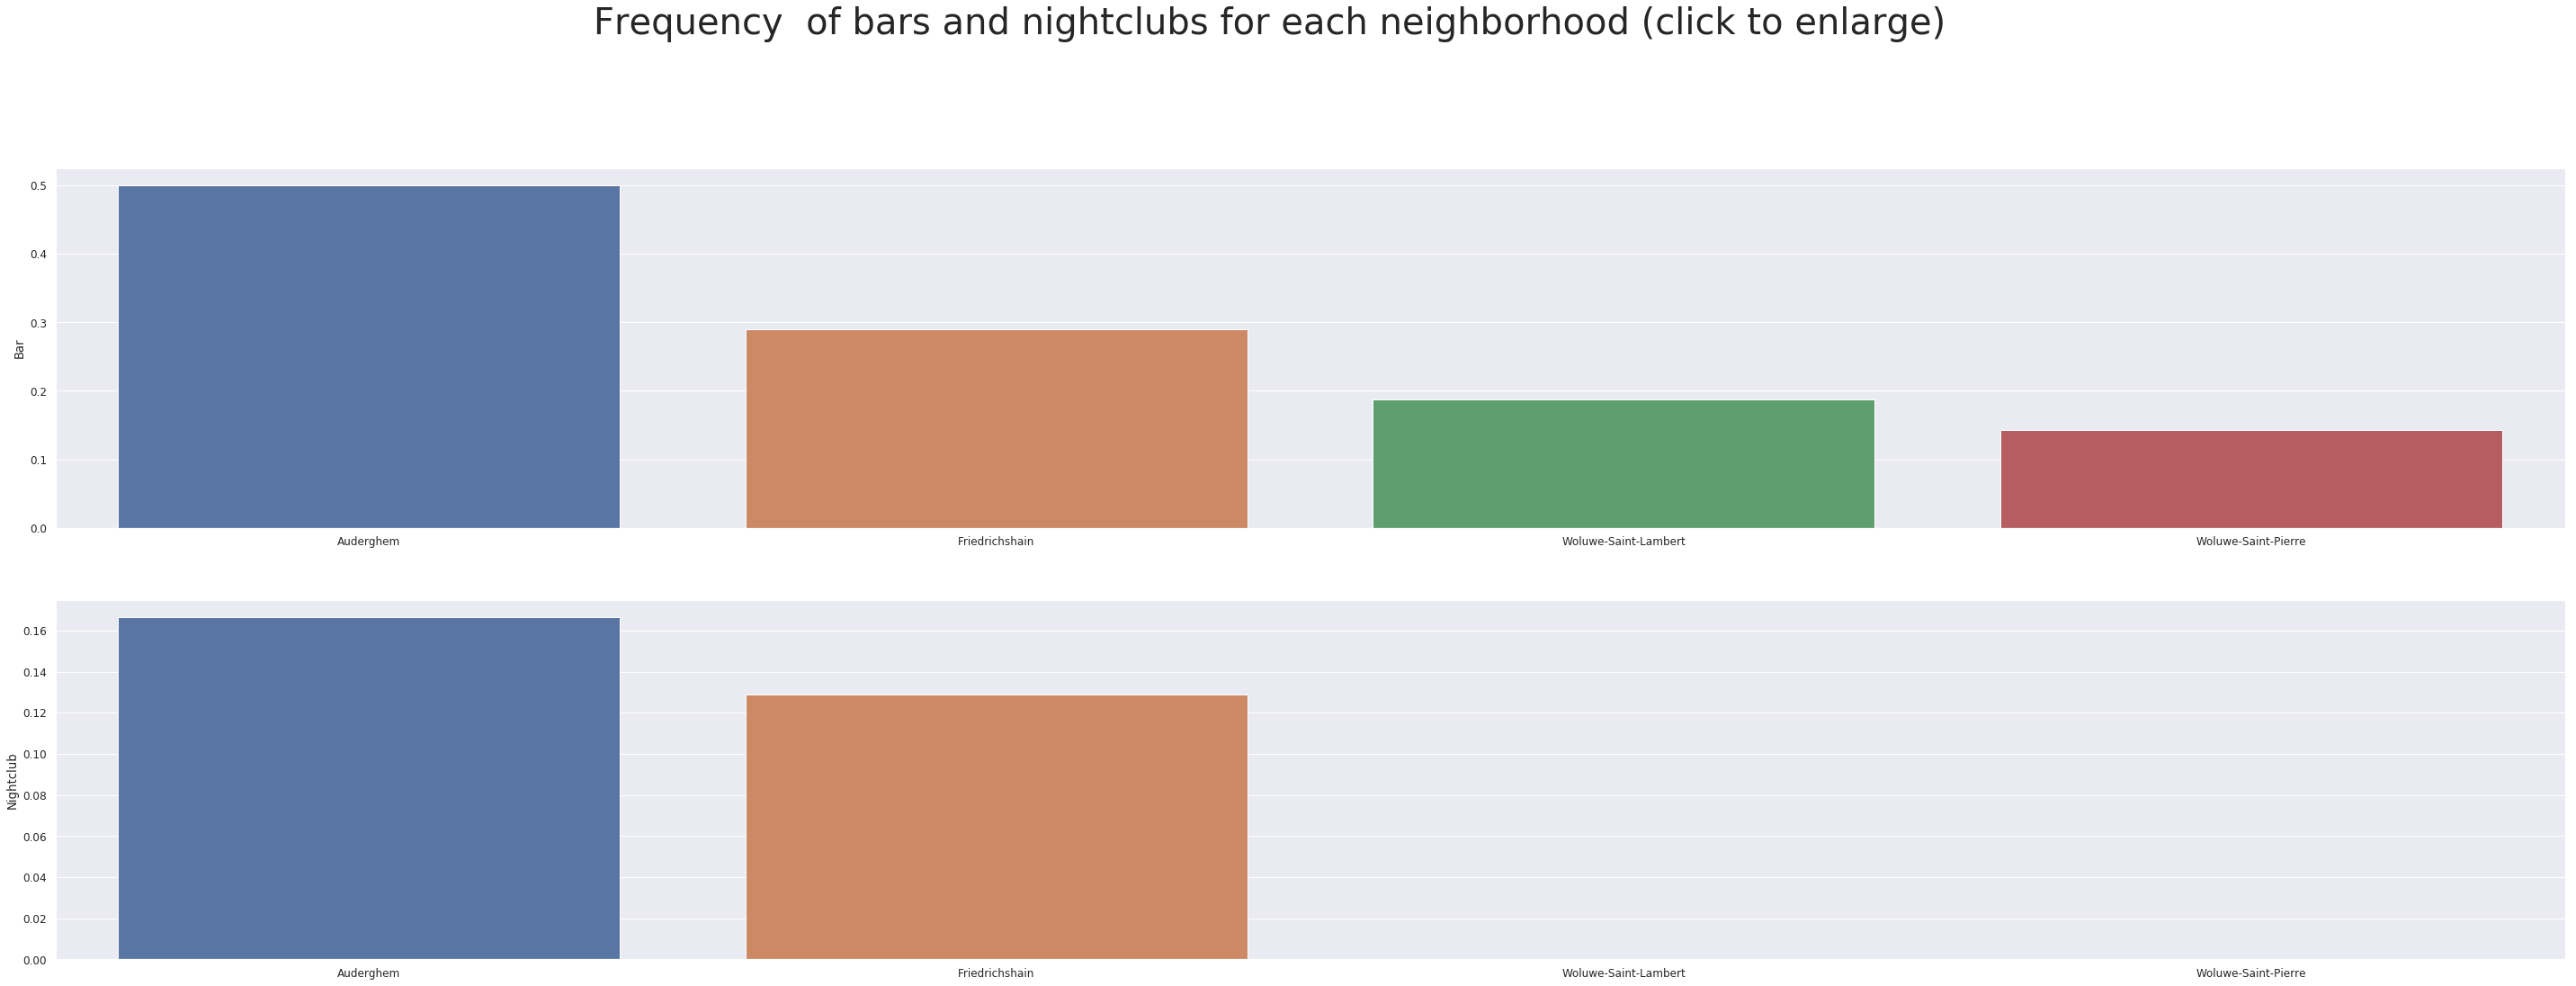

In [60]:
# Categorical plot
# The top 10 venue types as specified by the client for each neighborhood are used for the plotting.

import seaborn as sns
fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.barplot(x="Neighborhood", y="Bar", data=cl3_onehot);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.barplot(x="Neighborhood", y="Nightclub", data=cl3_onehot);
plt.xlabel("")


fig.suptitle('Frequency  of bars and nightclubs for each neighborhood (click to enlarge)', fontsize = 40)
plt.savefig ("Distribution.png", dpi=240)
plt.show()

## 5. Results & Discussion <a name="results"></a>

__1st Analysis__

When performing the clustering algorithm on the dataset, Friedrichshain was put in a cluster with Auderghem, Woluwe-Saint-Lambert and Woluwe-Saint-Pierre. Friedrichshain is an outer skirt district in Berlin, as are these Brussels' districts. Its plausible that being an outskirt district, the neighborhood consists of different venues compared to city-center districts. 

__2nd Analysis__

When analyzing the third cluster (with Friedrichshain), the explore function was specifically set to search for 'nightlife' venues only. After plotting the frequency of bars and nightclubs we can conclude the following: 

- In terms of bars present, Auderghem outperforms Woluwe-Saint-Lambert and Woluwe-Saint-Pierre with more than twice the amount.
- When we compare the nightclubs in each district, the data didn't show nightclubs for Woluwe-Saint-Lambert and Woluwe-Saint-Pierre, however, the foursquare explore function found even more nightclubs in Auderghem than in Friedrichshain. 

This tends to favor the neighborhood __Auderghem__ over the others, however, there are a few sidemarks that are worth mentioning:

- The initial clustering algorithm clustered the districts based on a general explore function, which gives *recommended* venues in the area. If all relevant venues would be considered and the dataset would be bigger (now 1700-ish rows), a more accurate dataset of venues would probably give us a better clustering of districts. 

- Even if we restricted the explore function to nightlife venues only, I'm confident not all clubs are being considered as Friedrichshain should have more clubs than all districts in Brussels combined. No clubs present in Woluwe is also doubtful. 

- Auderghem does have a lot of nightclubs and bars in the area and assuming people go out in places where there is already a lot of nightlife, favors Auderghem above the others. 

- An extra advantage for Auderghem is the presence of more nature and being a less residential area than Woluwe-Saint-Lambert and Woluwe-Saint-Pierre, which helps the case of noise disturbance reduction. 

## 6. Conclusion <a name="conclusion"></a>

Based on our analysis and the clustering algorithm, we can conclude that __Auderghem__ best meets the proposed criteria. The area has a lot of bars, nightclubs and has an environmental advantage. Further analyses could be made to further investigate to where exactly open a new techno club. 

There are many ways this analysis could've been performed based on different data sources or different machine learning algorithms. I opted for the k-clustering algorithm as it is straightforward and simple in many ways. Assumptions have been made and the data retrieved from foursquare is non-exhaustive, so Auderghem being the most favorable district is merely an outcome of this analysis in a limited environment and may or may not be the best district in real life. Domain knowledge of the industry, government regulations and restrictions regarding nightlife business and a more detailed demographic analysis for each district could benefit this research, and will probably change the outcome. We also didn't differentiate between types of nightclubs, as techno clubs attract a certain type of people. 

However, the result is here and based on what's been proposed and assumed, this is the best outcome. The data approach helps us to think out of the box, providing a new way of thinking and data-driven analyses will lead to critical thinking and a better solution in the end. 

Thanks for taking part in my Data Science journey!